In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from KDEpy import FFTKDE  # Fastest 1D algorithm

## estimate of count rate

### reichel fiber pigtail experiment

see page ~29 of Sebastien Garcia's thesis

In [47]:
# estimate s for the MOT beams

print("saturation parameter for one MOT beam")
50/3.576

saturation parameter for one MOT beam


13.982102908277405

In [67]:
s= 14*6 # they say s ~ 9 but later 
s = 0.8*6 # 6 beams, assumed non-interfering
gamma = 2*np.pi*6.06e6
det = 2.5*gamma
r = gamma*0.5*s/(1+4*(det/gamma)**2+s) # single beam scattering rate, two level atom. Mark's notes, Eq. 5.21
# NA = 0.43
# eta_lens = np.arcsin(NA)/(2*np.pi)
eta_lens = 0.02
eta_fiber = 0.6 # from their simulation of 780 mode overlap with the fiber
eta_det = 0.58 # APD
eta_AOM = 0.7
eta_bp = 0.9*0.94*0.95*0.96 # filter, bandpass, dichroic, MM fiber
other = 0.9 # spliced fiber after damage

# expected
eta_total = eta_lens*eta_fiber*eta_det*eta_AOM*eta_bp*other
print("expected collection efficiency",eta_total)
cnt_rate = r*eta_total
print(f"{cnt_rate:.2e} counts/s:")

# measured
eta_total = 0.0031
print("measured collection efficiency",eta_total)
cnt_rate = r*eta_total
print(f"{cnt_rate:.2e} counts/s:")

expected collection efficiency 0.003383101209599999
1.00e+04 counts/s:
measured collection efficiency 0.0031
9.20e+03 counts/s:


In [68]:
cnt_rate*0.01 # counts during exposure

91.97604092000704

In [50]:
# they estimate 2.3% of photons collected by the lens for isotropic
# emission. how?
NA = 0.43
eta_lens = np.arcsin(NA)/(2*np.pi)
eta_lens

0.0707432226179788

### network experiment

In [9]:
s = 11*6 # 6 beams, assumed non-interfering
ac_shift = 0
det = 2*np.pi*(15.5e6+ac_shift)
gamma = 2*np.pi*6.06e6
r = gamma*0.5*s/(1+4*(det/gamma)**2+s) # single beam scattering rate, two level atom. Mark's notes, Eq. 5.21
NA = 0.61
eta_lens = np.arcsin(NA)/(2*np.pi)
eta_fiber = 0.7
eta_det = 0.7
eta_bp = 0.9 # bandpasses
eta_total = eta_lens*eta_fiber*eta_bp*eta_det
eta_total  = 0.1*0.9*0.65 # sigma coupling to fiber from Chris's paper, bandpass+dichroic efficiency, SPCM
print(f"{r*eta_total:.2e} counts/s (trap off):")
ac_shift = 20e6 # estimated trap shift
det = 2*np.pi*(15.5e6+ac_shift)
r = gamma*0.5*s/(1+4*(det/gamma)**2+s) # single beam scattering rate, two level atom. Mark's notes, Eq. 5.21
print(f"{r*eta_total:.2e} counts/s (trap on):")

7.89e+05 counts/s (trap off):
3.60e+05 counts/s (trap on):


In [18]:
# estimate s for the MOT beams
eta_7030 = 0.7
eta_AOM = 0.7*0.7 # the AOMs are operated at roughly 70% of their max eff., which is about 70%
MOTchip_mW = 1 # before the beamsplitters and fiber launchers for MOT1-4
wMOT_cm = 0.06 # 600 um waist
P_MOT_mW = (eta_AOM*eta_7030*eta_fiber*MOTchip_mW) # single beam power (mW/cm^2)
I_MOT = 2*P_MOT_mW/(np.pi*wMOT_cm**2)
print("saturation parameter for one MOT beam")
I_MOT/3.576

saturation parameter for one MOT beam


11.873322718233924

In [14]:
(20/6)*0.7**4

0.8003333333333332

In [12]:
P_MOT_mW

0.8003333333333331

In [7]:
np.arcsin(0.61)/(2*np.pi)

0.10441528601349129

## simulation of histogram

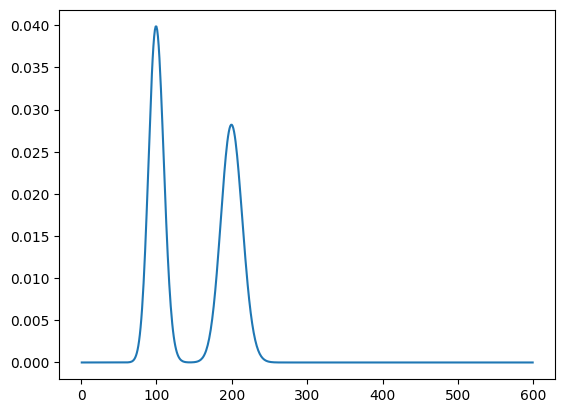

In [49]:
mu_bg = 100
mu_sig = 100 # the true signal mean 
poisson = lambda x, m: (m**x/np.math.factorial(x))*np.exp(-m)
func = lambda counts: poisson(counts, mu_bg) + poisson(counts, mu_sig+mu_bg)
counts = range(1,600)
plt.plot(counts, np.array([func(x) for x in counts]))

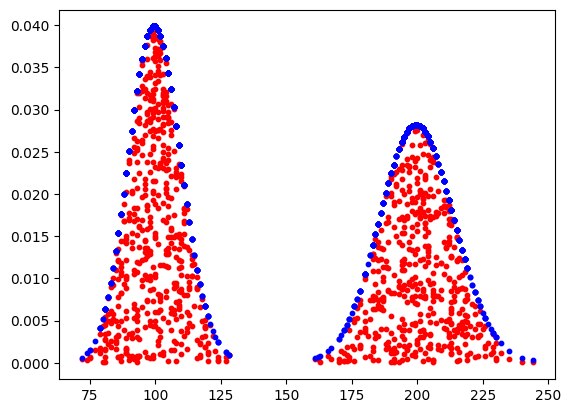

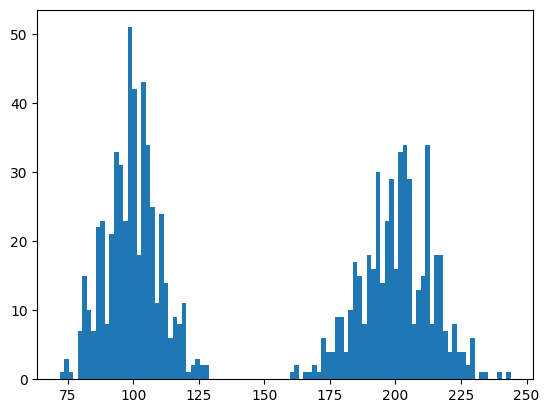

In [56]:
n = 1000 # number of measurements
domain = [0,500]
x1,x2 = domain

fmax = poisson(mu_bg, mu_bg) # the maximum
y_dist = np.empty(n) 
f_dist = np.empty(n)
x_dist = np.empty(n) # this is the distribution we want
j = 0 # dist index
while j < n:
    x = int((x2-x1)*np.random.rand()+0.5) # rand val on domain of f(x)
    f = func(x)
    y = np.random.rand()*fmax # rand val on range of f(x)
    if y <= f:
        y_dist[j]=y
        f_dist[j]=f
        x_dist[j]=x # x vals with approximate gaussian pdf
        j+=1

# check the generated pts
plt.scatter(x_dist,y_dist,c='red',s=10)
plt.scatter(x_dist,f_dist,c='blue',s=10)
plt.show()

# plot what we would want to see in lab
plt.hist(x_dist, bins=100)
plt.show()

In [57]:
# atom counts from a generator function

def sample_photocounts(measurements):
    mu_bg = 100 # the mean background
    mu_sig = 100 # the signal mean 
    poisson = lambda x, m: (m**x/np.math.factorial(x))*np.exp(-m)
    count_dist = lambda counts: poisson(counts, mu_bg) + poisson(counts, mu_sig+mu_bg)

    domain = [0,500] # assume we don't measure fewer than 0 or more than 500 counts
    x1,x2 = domain

    fmax = poisson(mu_bg, mu_bg) # the maximum
    y_dist = np.empty(n) 
    f_dist = np.empty(n)
    x_dist = np.empty(n) # this is the distribution we want
    j = 0 # dist index

    while j < measurements:

        x = int((x2-x1)*np.random.rand()+0.5) # rand val on domain of f(x)
        f = count_dist(x)
        y = np.random.rand()*fmax # rand val on range of f(x)
        if y <= f:
            y_dist[j]=y
            f_dist[j]=f
            x_dist[j]=x # x vals with approximate gaussian pdf
            j+=1
            yield x # the number of counts

In [65]:
gen = sample_photocounts(100)

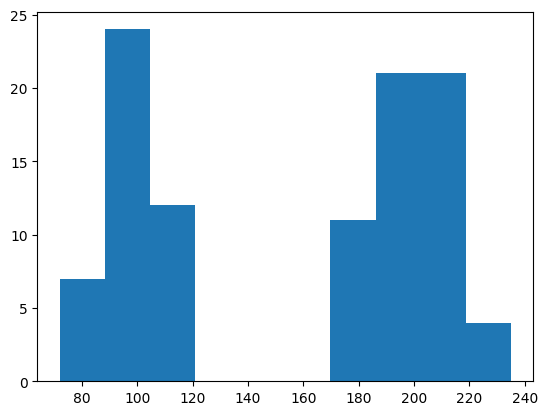

In [66]:
data = [i for i in gen]
plt.hist(data)
plt.show()

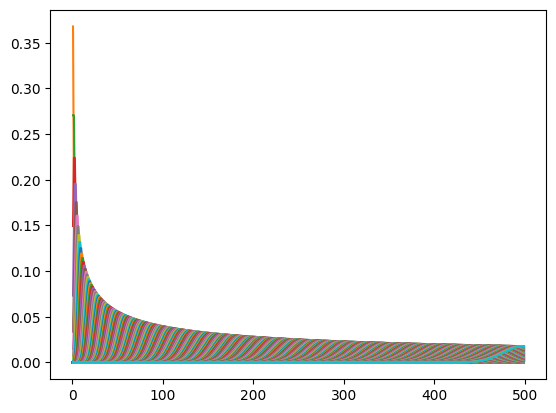

In [35]:
xpts = range(1,500)
for m in range(500):
    p = lambda x: (m**x/np.math.factorial(x))*np.exp(-m)
    ppts = [p(x) for x in xpts]
    plt.plot(xpts, ppts)

## cost function for determining number of loaded atoms
we want to load atoms with the MOT on in steady state, and optimize the number of atoms loaded. for this to work, we need to be able to do thresholding on the data, as the threshold can change based on where the MOT is wrt the trap, how hot it is, etc which changes how many photons an atom scatters before it is kicked out. however, we are not guaranteed to have a bimodal distribution in each measurement (if we load no atoms, there's just one mode for that data), so we need to be able to see if it even makes sense to find a threshold for the data.

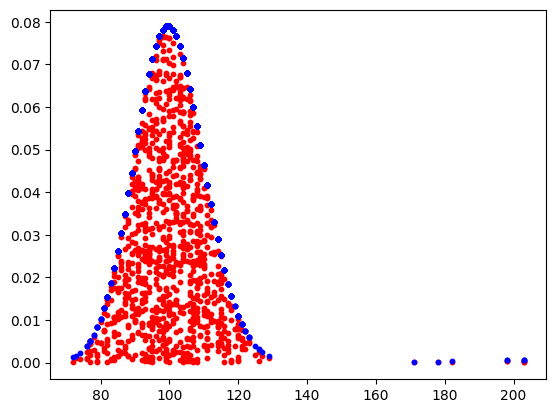

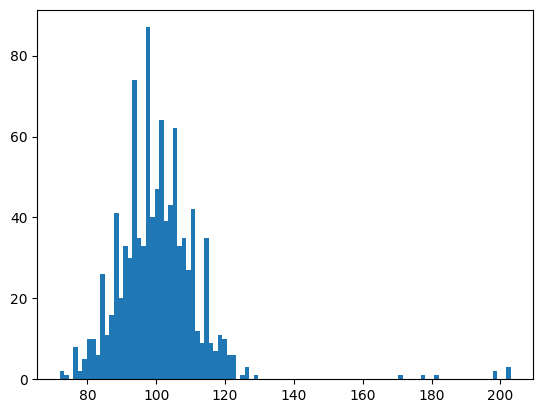

In [12]:
n = 100 # number of measurements
domain = [0,500]
x1,x2 = domain

mu_bg = 100
mu_sig = 100 # the true signal mean
poisson = lambda x, m: (m**x/math.factorial(x))*np.exp(-m)

a = 0.99 # the background fraction. kind of
b = 1 - a
func = lambda counts: 2*(a*poisson(counts, mu_bg) + b*poisson(counts, mu_sig+mu_bg))
# counts = range(1,600)
# plt.plot(counts, np.array([func(x) for x in counts]))

fmax = 2*a*poisson(mu_bg, mu_bg) # the maximum
y_dist = np.empty(n) 
f_dist = np.empty(n)
x_dist = np.empty(n) # this is the distribution we want
j = 0 # dist index
while j < n:
    x = int((x2-x1)*np.random.rand()+0.5) # rand val on domain of f(x)
    f = func(x)
    y = np.random.rand()*fmax # rand val on range of f(x)
    if y <= f:
        y_dist[j]=y
        f_dist[j]=f
        x_dist[j]=x # x vals with approximate gaussian pdf
        j+=1

# check the generated pts
plt.scatter(x_dist,y_dist,c='red',s=10)
plt.scatter(x_dist,f_dist,c='blue',s=10)
plt.show()

# plot what we would want to see in lab
plt.hist(x_dist, bins=100)
plt.show()

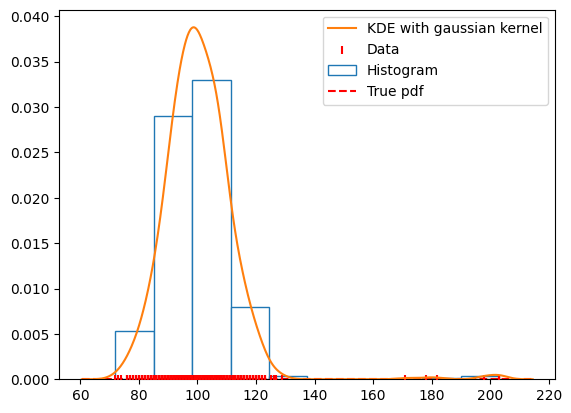

In [13]:
data = x_dist

# Use a box function with the FFTKDE to obtain a density estimate
kernel_type = 'gaussian'
x, y = FFTKDE(kernel=kernel_type, bw='ISJ').fit(data).evaluate()

plt.plot(x, y, zorder=10, color='#ff7f0e', label=f'KDE with {kernel_type} kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r',
            label='Data', zorder=9)
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.legend(loc='best');

In [19]:
def get_photocounts(n, a):
    """
    n: number of counts
    a: a float from 0. to 1., corresponding to only background events and only atom events, respectively
    """
    domain = [0,500]
    x1,x2 = domain
    
    mu_bg = 100
    mu_sig = 100 # the true signal mean
    poisson = lambda x, m: (m**x/math.factorial(x))*np.exp(-m)
    
    b = 1 - a
    func = lambda counts: 2*(a*poisson(counts, mu_bg) + b*poisson(counts, mu_sig+mu_bg))
    # counts = range(1,600)
    # plt.plot(counts, np.array([func(x) for x in counts]))
    
    fmax = 2*a*poisson(mu_bg, mu_bg) # the maximum
    y_dist = np.empty(n) 
    f_dist = np.empty(n)
    x_dist = np.empty(n) # this is the distribution we want
    j = 0 # dist index
    while j < n:
        x = int((x2-x1)*np.random.rand()+0.5) # rand val on domain of f(x)
        f = func(x)
        y = np.random.rand()*fmax # rand val on range of f(x)
        if y <= f:
            y_dist[j]=y
            f_dist[j]=f
            x_dist[j]=x # x vals with approximate gaussian pdf
            j+=1

    return x_dist

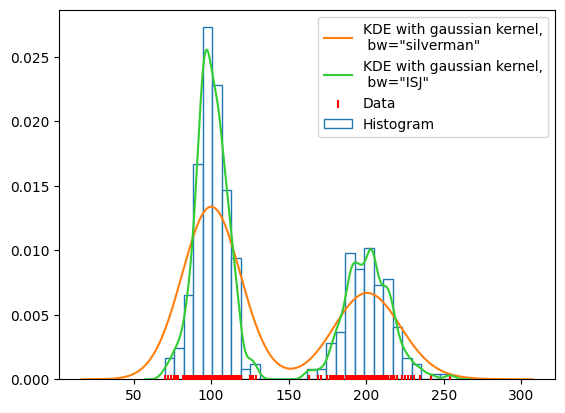

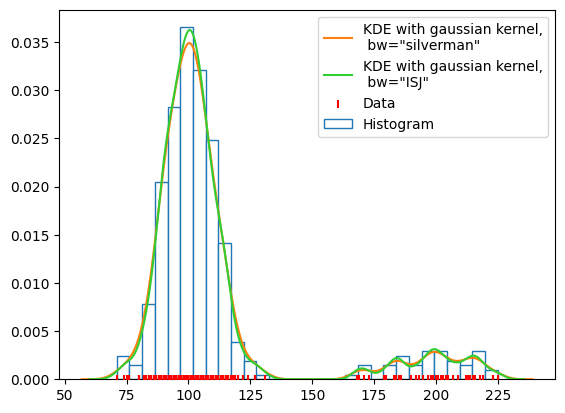

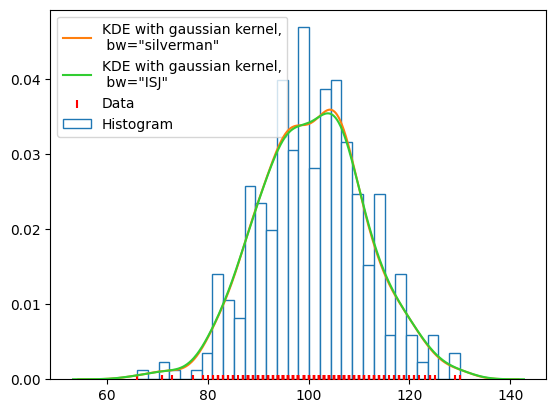

In [23]:
# compute how many modes there are, and, if more than one, do otsu thresholding. in my cost function, if there is only one mode, return 0

fig,ax = plt.subplots()

for a in [0.6,0.9,1]:
    data = get_photocounts(400,a)
    kernel_type = 'gaussian'
    bw='silverman'
    x, y = FFTKDE(kernel=kernel_type, bw=).fit(data).evaluate()
    plt.plot(x, y, zorder=10, color='#ff7f0e', label=f'KDE with {kernel_type} kernel,\n bw="{bw}"')
    
    bw='ISJ'
    x, y = FFTKDE(kernel=kernel_type, bw=bw).fit(data).evaluate()
    plt.plot(x, y, zorder=10, color='limegreen', label=f'KDE with {kernel_type} kernel,\n bw="{bw}"')
    plt.scatter(data, np.zeros_like(data), marker='|', c='r',
                label='Data', zorder=9)
    plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w',bins=30)
    plt.legend(loc='best')
    plt.show()

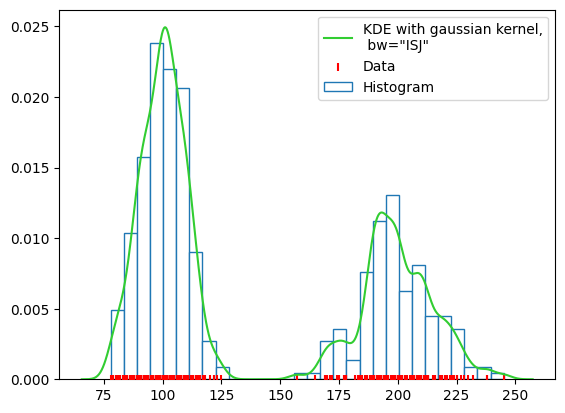

In [49]:
# compute how many modes there are, and, if more than one, do otsu thresholding. in my cost function, if there is only one mode, return 0

fig,ax = plt.subplots()

for a in [0.6]:#,0.9,1]:
    data = get_photocounts(400,a)
    kernel_type = 'gaussian'
    
    bw='ISJ'
    x, y = FFTKDE(kernel=kernel_type, bw=bw).fit(data).evaluate()
    plt.plot(x, y, zorder=10, color='limegreen', label=f'KDE with {kernel_type} kernel,\n bw="{bw}"')
    plt.scatter(data, np.zeros_like(data), marker='|', c='r',
                label='Data', zorder=9)
    
    plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w',bins=30)
    plt.legend(loc='best')
    plt.show()

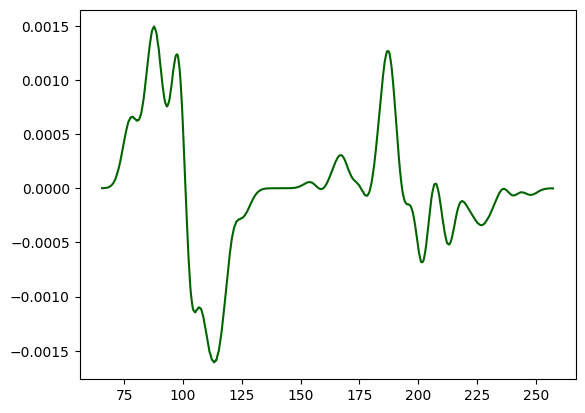

In [51]:
dydx = np.gradient(y,x)
plt.plot(x,dydx,color='darkgreen',label='deriv of KDE')

In [39]:
x.shape,y.shape

((1024,), (1024,))

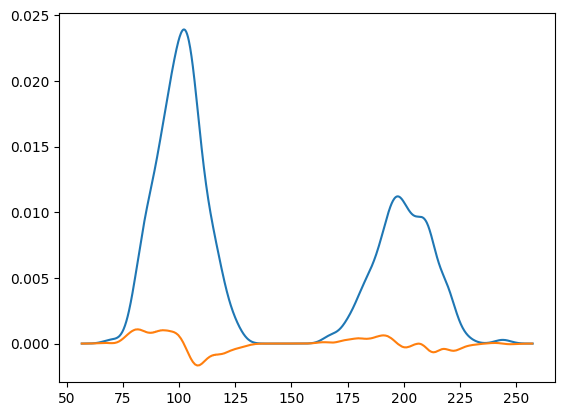

In [47]:
plt.plot(x,y)
dx = x[1]-x[0]
dydx = np.array([(y[i+1]-y[i])/dx for i in range(len(y)-1)])
plt.plot(x[:-1],dydx)

In [36]:
len(dydx), len(y)

(1024, 1024)

In [ ]:
bw='silverman'
x, y = FFTKDE(kernel=kernel_type, bw=).fit(data).evaluate()

plt.plot(x, y, zorder=10, color='#ff7f0e', label=f'KDE with {kernel_type} kernel,\n bw="{bw}"')

### kernel smooting with KDEpy example

In [5]:
from scipy.stats import norm

np.random.seed(123)  # Seed generator for reproducible results

distribution = norm()  # Create normal distribution
data = distribution.rvs(32)  # Draw 32 random samples

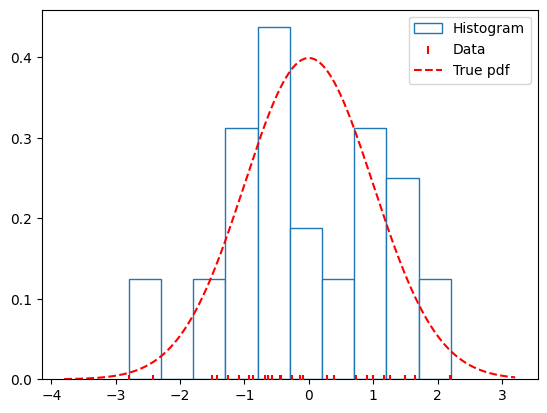

In [6]:
x = np.linspace(np.min(data) - 1, np.max(data) + 1, num=2**10)

plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.scatter(data, np.zeros_like(data), marker='|',
            c='r', label='Data', zorder=9)
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

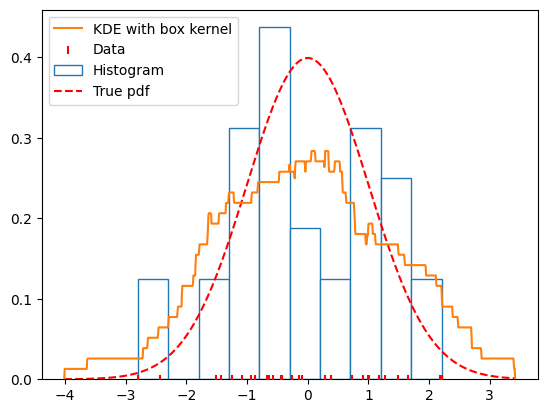

In [8]:
np.random.seed(123)
data = distribution.rvs(32)

# Use a box function with the FFTKDE to obtain a density estimate
x, y = FFTKDE(kernel='box', bw=0.7).fit(data).evaluate()

plt.plot(x, y, zorder=10, color='#ff7f0e', label='KDE with box kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r',
            label='Data', zorder=9)
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

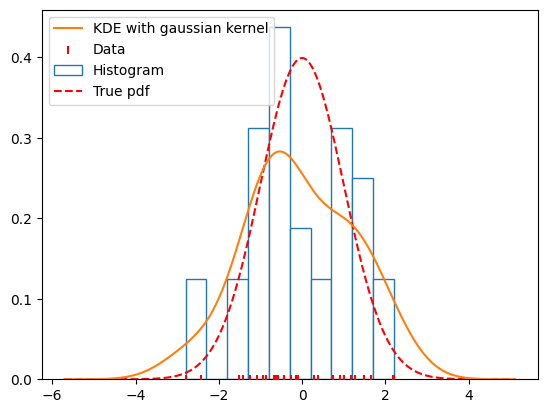

In [10]:
np.random.seed(123)
data = distribution.rvs(32)

# Use a box function with the FFTKDE to obtain a density estimate
kernel_type = 'gaussian'
x, y = FFTKDE(kernel=kernel_type, bw=0.7).fit(data).evaluate()

plt.plot(x, y, zorder=10, color='#ff7f0e', label=f'KDE with {kernel_type} kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r',
            label='Data', zorder=9)
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');